## Import the packages / functions

In [104]:
import matplotlib as mpl
# mpl.use("pgf")
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from tqdm.notebook import trange
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from functools import partial

import torch
import vjf
from vjf import online

from tqdm.notebook import trange

## Import the dataset (pick one!) 

#### run the cell below for the example lorenz attractor dataset 

In [82]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 2500 time points, with noise sd=0.05)
data = np.load('lorenz_1trajectories_3dim_500to2500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example vanderpol dataset 

In [84]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 2500 time points, with noise sd=0.05)
data = np.load('vdp_1trajectories_2dim_500to2500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example jPCA dataset

In [105]:
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 2
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example Neuropixel dataset

In [93]:
import scipy.io as sio
matdict = sio.loadmat('WaksmanwithFaces_KS2.mat', squeeze_me=True)
spks = matdict['stall']
spks = spks[..., None]

xs = None  # state
ys = spks  # observation
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 3 # hidden state dimension
ydim = ys.shape[-1]
udim = us.shape[-1]

## Derivation 
ref: http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf

$ p(y_t \vert y_{\leq{t-1}}) = \iint p(y_t \vert x_t) p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) dx_{t-1} dx_t $


* $ p(x_{t-1} \vert y_{\leq{t-1}}) \longrightarrow \text{filtering}\longrightarrow N(\mu_f, \Sigma_f) \in \mathbb{R}^dx $ 


* $ p(x_t \vert x_{t-1}) \longrightarrow \text{transition} \longrightarrow N(W_s x_{t-1}, \Sigma_s) \in \mathbb{R}^dx $


* $ p(x_t \vert y_{\leq{t-1}}) = p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) \sim N(W_s \mu_f, W_s \Sigma_f W^T_s + \Sigma_s)$


* $ p(y_t \vert x_t) \longrightarrow \text{decoder} \longrightarrow N(W_d x_t + b_d, \Sigma_d)$


* $ p(y_t \vert y_{\leq{t-1}}) = N(W_d W_s \mu_f + b_d, W_d (W_s \Sigma_f W_s^T + \Sigma_s) W_d^T + \Sigma_d)$

## Fit the model & save the log probability 
(Important to Note that the dynamics is now 'RBF')

In [106]:
device = 'cpu'

In [107]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'rbf'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
).to(device)

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 6}
Gaussian likelihood


In [108]:
yy = torch.from_numpy(ys).float().to(device)
uu = torch.from_numpy(us).float().to(device)

EXAMPLE = 0  # the example for calculating the likelihood

# yy = torch.from_numpy(ys[EXAMPLE]).float()
# uu = torch.from_numpy(us[EXAMPLE]).float()

q = None

logprobs = []
distances = []

Note that we are using only the first trajectory to compute the log probability.

We can combine all of the trajectories to make the training better & noise lower.

In [109]:
logprobs = []
distances = []
x_pred = []
y_pred = []

for trial in trange(yy.shape[0]):
    batch_size = 1
    filtering_mu = torch.zeros(batch_size, xdim, device=device)
    filtering_logvar = torch.zeros(batch_size, xdim, device=device)
    q = filtering_mu, filtering_logvar
    logprob_per_trial = []
    
    for time in range(yy.shape[1]):

        y = yy[trial, time].unsqueeze(0)
        u = uu[trial, time].unsqueeze(0)
        q, loss = mdl.feed((y, u), q)

        if trial%10 == 0:
        
            filtering_mu, filtering_logvar = q

            mu_f = filtering_mu[0].detach().cpu().numpy().T
            var_f = filtering_logvar[EXAMPLE].detach().exp().cpu().numpy().T
            Sigma_f = np.eye(xdim) * var_f

            x_pred.append(mu_f)

            N = 100
            x = multivariate_normal(mu_f.flatten(), Sigma_f).rvs(size=N).astype(np.float32)
            x = torch.from_numpy(x).to(device)
            x += mdl.system.velocity(x)
            y_tilde = mdl.decoder(x).detach().cpu().numpy()
            y_pred.append(y_tilde)
            y_var = mdl.likelihood.logvar.detach().exp().cpu().numpy().T
            logprob = logsumexp([multivariate_normal(y_t, y_var).logpdf(y.cpu().numpy()) for y_t in y_tilde]) - np.log(N)

            logprob_per_trial.append(logprob)
            distances.append(np.linalg.norm(y_tilde - y[EXAMPLE].cpu().numpy(), axis=-1).mean())
        
    if len(logprob_per_trial) > 0:
        logprobs.append(logprob_per_trial)

## Plotting the log probability 

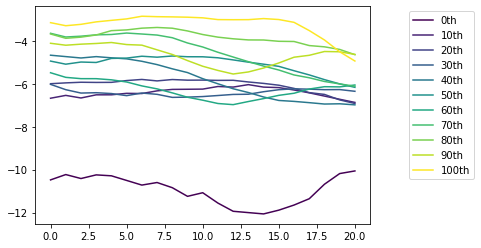

In [110]:
from matplotlib.cm import get_cmap

cm = get_cmap("viridis")
colors = cm(np.linspace(0, 1, len(logprobs)))
colors.shape

for i, curve in enumerate(logprobs):
    plt.plot(curve, c=colors[i], label= f"{i * 10}th")
plt.legend(bbox_to_anchor=(1.1, 1.0))

## Plotting the L2 distance

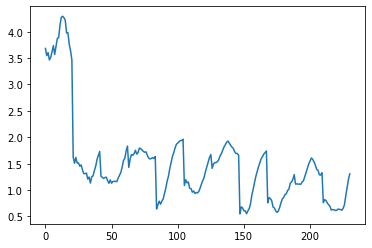

In [111]:
plt.plot(distances)